# ml.g5.2xlarge vs. ml.p3.2xlarge for training RoBERTa model on a single GPU Training 

## Introduction

This notebook shows how to evaluate which instance to use to train faster and chaper. It includes measures time-to-train and cost-to-train the task of fine-tuning a Hugging Face `RoBERTa` model, while validating model quality is kept the same.
We benchmark two instance types (you could try different instance types, of course):
- `ml.p3.2xlarge` - Single NVIDIA V100 GPU, 8 vCPUs, available in SageMaker since 2018.
- `ml.g5.2xlarge` - Single NVIDIA A10g GPU, 8 vCPUs, available in SageMaker since Jan 2022.

In [1]:
# We'll train and compare using these two instance types
INSTANCE1_TYPE = "ml.p3.2xlarge"
INSTANCE1_BATCH_SIZE = 18 # Max for ml.p3.2xlarge
INSTANCE2_TYPE = "ml.g5.2xlarge" # Can change to "ml.g5.xlarge"
INSTANCE2_BATCH_SIZE = 18 # G5 supports up to 24

 ## Summary of results
Results are presented here (run the notebook to reproduce):

|               | ml.p3.2xlarge | ml.g5.2xlarge|
|---------------|---------------|--------------|
| Cost to train | $4.68         | $2.46        |
| Time to train | 3935s         | 5414s        |

Observations:
* Training on `ml.g5.2xlarge` is much more cost-efficient than on `ml.p3.2xlarge` (cuts cost by 47%).
* Training on `ml.p3.2xlarge` is about 27% faster than on `ml.g5.2xlarge`.
* You'll want to go with `ml.p3.2xlarge` if you're willing to pay roughly 2x to complete training 27% faster. Otherwise `ml.g5.2xlarge` is your choice.

### Optimizing further
We've cut training cost by 47% by switching to `ml.g5.2xlarge` instance. We've picked `ml.g5.2xlarge` since is has the same amount of vCPUs (8), as `p3.2xlarge`. This switch is a low hanging fruit, as it requires changing a single line of code when launching the training job using the SageMaker Python SDK: `sagemaker.huggingface.HuggingFace(instance_type=...)`.
If we're willing to invest more tuning effort, there two more tricks we could apply to futher improve results in favor of G5: Increasing batch size, and scaling down to a `ml.g5.xlarge` instance. These are detailed below. Here's the table again, now with a 3rd column for `ml.g5.xlarge`. We can see the cost to train drops to $2.29 which is 51% lower than cost to train on `ml.p3.2xlarge`.

|               | ml.p3.2xlarge | ml.g5.2xlarge| ml.g5.xlarge|
|---------------|---------------|--------------|-------------|
| Cost to train | $4.68         | $2.46        | $2.29       |
| Time to train | 3935s         | 5414s        | 5438s       |
| batch size    | 18            | 18           | 24          |

#### 1. Increasing batch_size
Increasing the batch size of examples per mini batch can typically result in higher throughput. The `ml.p3.2xlarge` instance has 16GB GPU RAM and can fit a maximum batch size of `18`. The `ml.g5.*` instance has more GPU RAM (24GB), and can fit a maxiumum batch size of `24` (I found this value by extrapulating, and running experiments to find the largest batch size that will fit into GPU memory). Here's how results change taking advantage of the higher batch size for G5:
TODO

#### 2. Scaling down from `ml.g5.2xlarge` to `ml.g5.xlarge`:
As this training job is GPU bound, we have redudant cpu power on both instances. As G5 instances has a range of CPU/GPU ratios, we can scale down to from ml.g5.2xlarge with 8 vCPUs to an ml.g5.xlarge with 4 vCPUs to improve cost-to-train, while not compromising on time-to-train. Note that `ml.p3.2xlarge` is the minimal P series instance, so there's no scale down option.  
Here's the new results with an increased batch size for G, and using `ml.g5.xlarge`:
TODO

---

**CREDITS:** Much of the code in this notebook is based on this SageMaker example notebook: [Compile and Train a Hugging Face Transformer BERT Model with the SST Dataset using SageMaker Training Compile](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-training-compiler/huggingface/pytorch_single_gpu_single_node/bert-base-cased/bert-base-cased-single-node-single-gpu.ipynb)

## Development Environment 

You can run this demo in SageMaker Studio, SageMaker notebook instances, or your local machine with AWS CLI set up. If using SageMaker Studio or SageMaker notebook instances, make sure you choose one of the PyTorch-based kernels, `Python 3 (PyTorch x.y Python 3.x CPU Optimized)` or `conda_pytorch_p36` respectively.

This notebook runs training jobs with `ml.g5.2xlarge` and `ml.p3.2xlarge` instances types - If you don't have enough quota, see [Request a service quota increase for SageMaker resources](https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html#service-limit-increase-request-procedure). 

### Installation

This example notebook was tested with **SageMaker Python SDK v2.77.1** and **transformers v4.11.0**, in the **us-east-1** region.

In [2]:
!pip install --upgrade pip
!pip install transformers==4.11.0 datasets sagemaker==2.77.1 botocore boto3 awscli torch matplotlib --upgrade

In [3]:
import botocore
import boto3
import sagemaker
import transformers
import pandas as pd

print(f"sagemaker: {sagemaker.__version__}")
print(f"transformers: {transformers.__version__}")

sagemaker: 2.77.1
transformers: 4.11.0


Copy and run the following code if you need to upgrade ipywidgets for `datasets` library and restart kernel. This is only needed when prerpocessing is done in the notebook.

```python
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
# has to restart kernel for the updates to be applied
IPython.Application.instance().kernel.do_shutdown(True) 
```

### SageMaker environment 

In [4]:
import sagemaker

sess = sagemaker.Session()

# SageMaker session bucket -> used for uploading data, models and logs
# SageMaker will automatically create this bucket if it does not exist
sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    # Add your own role if running outside of a SageMaker notebook environment (like local IDE)
    role = "arn:aws:iam::123456789000:role/service-role/AmazonSageMaker-ExecutionRole-20171221T130536"
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

Couldn't call 'get_role' to get Role ARN from role name Administrator to get Role path.


sagemaker role arn: arn:aws:iam::123456789000:role/service-role/AmazonSageMaker-ExecutionRole-20171221T130536
sagemaker bucket: sagemaker-us-east-1-123456789000
sagemaker session region: us-east-1


## Loading the SST dataset

When using the [🤗 Datasets library](https://github.com/huggingface/datasets), datasets can be downloaded directly with the following `datasets.load_dataset()` method:

```python
from datasets import load_dataset
load_dataset('dataset_name')
```

If you'd like to try other training datasets later, you can simply use this method.

For this example notebook, we prepared the `SST2` dataset in the public SageMaker sample file S3 bucket. The following code cells show how you can directly load the dataset and convert to a HuggingFace DatasetDict.

## Preprocessing

We download and preprocess the `SST2` dataset from the `s3://sagemaker-sample-files/datasets` bucket. After preprocessing, we'll upload the dataset to the `sagemaker_session_bucket`, which will be used as a data channel for the training job.

### Tokenization 

In [5]:
from datasets import Dataset
from transformers import AutoTokenizer
import pandas as pd

# tokenizer used in preprocessing
tokenizer_name = "roberta-base"

# s3 key prefix for the data
s3_prefix = "samples/datasets/sst2"

# Download the SST2 data from s3
!curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.test > ./sst2.test
!curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.train > ./sst2.train
!curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/text/SST2/sst2.val > ./sst2.val

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189k  100  189k    0     0   150k      0  0:00:01  0:00:01 --:--:--  151k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3716k  100 3716k    0     0   407k      0  0:00:09  0:00:09 --:--:--  491k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94916  100 94916    0     0  92982      0  0:00:01  0:00:01 --:--:-- 93883


In [6]:
# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)


# load dataset
test_df = pd.read_csv("sst2.test", sep="delimiter", header=None, engine="python", names=["line"])
train_df = pd.read_csv("sst2.train", sep="delimiter", header=None, engine="python", names=["line"])

test_df[["label", "text"]] = test_df["line"].str.split(" ", 1, expand=True)
train_df[["label", "text"]] = train_df["line"].str.split(" ", 1, expand=True)

test_df.drop("line", axis=1, inplace=True)
train_df.drop("line", axis=1, inplace=True)

test_df["label"] = pd.to_numeric(test_df["label"], downcast="integer")
train_df["label"] = pd.to_numeric(train_df["label"], downcast="integer")

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

/Users/gili/dev/g5-roBERTa-benchmark/.venv/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  8.34ba/s]


## Uploading data to `sagemaker_session_bucket`

In [7]:
import botocore

# save train_dataset to s3
training_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/train"
train_dataset.save_to_disk('/tmp/train')
!aws s3 sync /tmp/train {training_input_path}

# save test_dataset to s3
test_input_path = f"s3://{sess.default_bucket()}/{s3_prefix}/test"
test_dataset.save_to_disk('/tmp/test')
!aws s3 sync /tmp/test {test_input_path}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
upload: ../../../../../../tmp/train/state.json to s3://sagemaker-us-east-1-123456789000/samples/datasets/sst2/train/state.json
upload: ../../../../../../tmp/train/dataset_info.json to s3://sagemaker-us-east-1-123456789000/samples/datasets/sst2/train/dataset_info.json
upload: ../../../../../../tmp/train/dataset.arrow to s3://sagemaker-us-east-1-123456789000/samples/datasets/sst2/train/dataset.arrow
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environmen

## SageMaker Training Job

To create a SageMaker training job, we use a `HuggingFace` estimator. Using the estimator, you can define which fine-tuning script should SageMaker use through `entry_point`, which `instance_type` to use for training, which `hyperparameters` to pass, and so on.

When a SageMaker training job starts, SageMaker takes care of starting and managing all the required machine learning instances, picks up the `HuggingFace` Deep Learning Container, uploads your training script, and downloads the data from `sagemaker_session_bucket` into the container at `/opt/ml/input/data`.

In the following section, you learn how to set up two versions of the SageMaker `HuggingFace` estimator, a native one without the compiler and an optimized one with the compiler.

### Training Setup

Set up an option for fine-tuning or full training. Set `FINE_TUNING = 1` for fine-tuning and using `fine_tune_with_huggingface.py`. Set `FINE_TUNING = 0` for full training and using `full_train_roberta_with_huggingface.py`.

In [8]:
# Here we configure the training job. Please configure the appropriate options below:

# Fine tuning trains a pre-trained model on a different dataset whereas full training trains the model from scratch.
FINE_TUNING = True
FULL_TRAINING = not FINE_TUNING

# Fine tuning is typically faster and is done for fewer epochs
EPOCHS = 4 if FINE_TUNING else 100

TRAINING_SCRIPT = (
    "fine_tune_with_huggingface.py" if FINE_TUNING else "full_train_roberta_with_huggingface.py"
)

### Setting up training configuration

In [9]:
from sagemaker.huggingface import HuggingFace

# Note that the training batch size directly affects the learning rate we'll use
def get_hyperparameters(train_batch_size):
    # hyperparameters, which are passed into the training job
    hyperparameters = {"epochs": EPOCHS, "train_batch_size": train_batch_size, "model_name": "roberta-base"}
    # The original LR was set for a batch of 32. Here we are scaling learning rate with batch size.
    hyperparameters["learning_rate"] = float("5e-5") / 32 * hyperparameters["train_batch_size"]
    return hyperparameters


def start_training_job(instance_type, hyperparameters):
    estimator = HuggingFace(
        entry_point=TRAINING_SCRIPT,
        source_dir="./scripts",
        instance_type=instance_type,
        instance_count=1,
        role=role,
        py_version="py38",
        transformers_version="4.11.0",
        pytorch_version="1.9.0",
        volume_size=60 + 2 * hyperparameters["epochs"], # If checkpointing is enabled with higher epoch numbers, your disk requirements will increase as well
        hyperparameters=hyperparameters,
        disable_profiler=True,
        debugger_hook_config=False,
    )

    # start training with our uploaded datasets as input
    estimator.fit({"train": training_input_path, "test": test_input_path}, wait=False)
    return estimator

### Starting a training job per each instance type
The `train_batch_size=18` in the following code cell is the maximum batch that can fit into the memory of an `ml.p3.2xlarge` instance. If you change the model, instance type, sequence length, and other parameters, you need to do some experiments to find the largest batch size that will fit into GPU memory.
While `ml.g5.2xlarge` has more GPU RAM than `ml.p3.2xlarge`, and can handle a larger batch size of `24`, we benchmark with the origianl batch size to keep things simple.

In [10]:
instance1_estimator = start_training_job(INSTANCE1_TYPE, get_hyperparameters(train_batch_size=18))
print(f'Training job on {INSTANCE1_TYPE} name is: {instance1_estimator.latest_training_job.name}')

instance2_estimator = start_training_job(INSTANCE2_TYPE, get_hyperparameters(train_batch_size=18))
print(f'Training job on {INSTANCE2_TYPE} name is: {instance2_estimator.latest_training_job.name}')

Training job on ml.p3.2xlarge name is: huggingface-pytorch-training-2022-04-03-07-58-50-951
Training job on ml.g5.2xlarge name is: huggingface-pytorch-training-2022-04-03-07-58-54-457


### Training with Optimized PyTorch

### Wait for training jobs to complete

In [11]:
waiter = instance1_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=instance1_estimator.latest_training_job.name)

waiter = instance2_estimator.sagemaker_session.sagemaker_client.get_waiter(
    "training_job_completed_or_stopped"
)
waiter.wait(TrainingJobName=instance2_estimator.latest_training_job.name)

## Analysis

In [12]:
%%capture instance1_logs

# access the logs of the p3 training job
instance1_estimator.sagemaker_session.logs_for_job(instance1_estimator.latest_training_job.name)

**Note:** If the estimator object is no longer available due to a kernel break or refresh, you need to directly use the training job name and manually attach the training job to a new HuggingFace estimator. For example:
```python
my_estimator = HuggingFace.attach("your_huggingface_training_job_name")
```

In [13]:
%%capture instance2_logs

# access the logs of the g5 training job
instance2_estimator.sagemaker_session.logs_for_job(instance2_estimator.latest_training_job.name)

### Create helper functions for analysis

In [14]:
from ast import literal_eval
from collections import defaultdict
from matplotlib import pyplot as plt


def _summarize(captured):
    final = []
    for line in captured.stdout.split("\n"):
        cleaned = line.strip()
        if "{" in cleaned and "}" in cleaned:
            final.append(cleaned[cleaned.index("{") : cleaned.index("}") + 1])
    return final


def make_sense(string):
    try:
        return literal_eval(string)
    except:
        pass


def summarize(summary):
    final = {"train": [], "eval": [], "summary": {}}
    for line in summary:
        interpretation = make_sense(line)
        if interpretation:
            if "loss" in interpretation:
                final["train"].append(interpretation)
            elif "eval_loss" in interpretation:
                final["eval"].append(interpretation)
            elif "train_runtime" in interpretation:
                final["summary"].update(interpretation)
    return final

### Plot and compare throughputs for both instance types

Visualize average throughputs as reported by HuggingFace and see potential savings.

In [15]:
# collect the average throughput as reported by HF for first instance type training job
s1 = summarize(_summarize(instance1_logs))
instance1_throughput = s1["summary"]["train_samples_per_second"]

# collect the average throughput as reported by HF for the second instance type training job
s2 = summarize(_summarize(instance2_logs))
instance2_throughput = s2["summary"]["train_samples_per_second"]

# Calculate speedup for migrating to second instance type
avg_speedup = f"{round((instance2_throughput/instance1_throughput-1)*100)}%"

([<matplotlib.axis.XTick at 0x7fd51fec63d0>,
 [Text(1.0, 0, 'ml.p3.2xlarge'), Text(1.5, 0, 'ml.g5.2xlarge')])

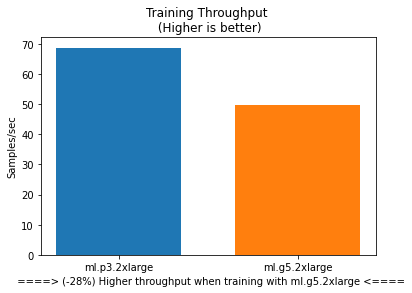

In [16]:
%matplotlib inline

plt.title("Training Throughput \n (Higher is better)")
plt.ylabel("Samples/sec")

plt.bar(x=[1], height=instance1_throughput, label=INSTANCE1_TYPE, width=0.35)
plt.bar(x=[1.5], height=instance2_throughput, label=INSTANCE2_TYPE, width=0.35)

plt.xlabel("  ====> ({}) Higher throughput when training with {} <====".format(avg_speedup,INSTANCE2_TYPE))
plt.xticks(ticks=[1, 1.5], labels=[INSTANCE1_TYPE, INSTANCE2_TYPE])

### Convergence of Training Loss

Let's validate model convergence behavior is similar when training on both instance types.

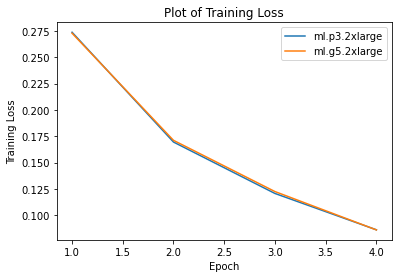

In [17]:
vanilla_loss = [i["loss"] for i in s1["train"]]
vanilla_epochs = [i["epoch"] for i in s1["train"]]
optimized_loss = [i["loss"] for i in s2["train"]]
optimized_epochs = [i["epoch"] for i in s2["train"]]

plt.title("Plot of Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(vanilla_epochs, vanilla_loss, label=INSTANCE1_TYPE)
plt.plot(optimized_epochs, optimized_loss, label=INSTANCE2_TYPE)
plt.legend()

### Evaluation Stats

Let's validate the quality of the model is the same for models trained on both instance types. Here, we compare the evaluation metrics of the models trained on ml.p3.2xlarge and on ml.g5.2xlarge.

In [18]:
import pandas as pd

table = pd.DataFrame([s1["eval"][-1], s2["eval"][-1]], index=[INSTANCE1_TYPE, INSTANCE2_TYPE])
table.drop(columns=["eval_runtime", "eval_samples_per_second", "epoch"])

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_steps_per_second
ml.p3.2xlarge,0.207803,0.949777,0.950658,0.934267,0.967634,1.685
ml.g5.2xlarge,0.217268,0.950335,0.951018,0.938111,0.964286,2.101


### Training Stats

Let's compare various cost/efficiency and quality training metrics for the models trained on both instance types.

In [19]:
first_instance_time_to_train = int(s1["summary"]['train_runtime'])
second_instance_time_to_train = int(s2["summary"]['train_runtime'])
pd.DataFrame([s1["summary"], s2["summary"]], index=[INSTANCE1_TYPE, INSTANCE2_TYPE])

,train_runtime,train_samples_per_second,train_steps_per_second,train_loss,epoch
ml.p3.2xlarge,3917.6365,68.765,3.820,0.162547,4.0
ml.g5.2xlarge,5413.7689,49.761,2.764,0.163141,4.0


In [20]:
# calculate percentage speedup from migrating to g5 in terms of total training time reported by HF

speedup = (
    (s1["summary"]["train_runtime"] - s2["summary"]["train_runtime"])
    * 100
    / s1["summary"]["train_runtime"]
)
print(
    f"Training on {INSTANCE2_TYPE} is about {int(speedup)}% faster in terms of total training time as reported by HF, than training on {INSTANCE1_TYPE}."
)

Training on ml.g5.2xlarge is about -38% faster in terms of total training time as reported by HF, than training on ml.p3.2xlarge.


### Total Billable Time

Finally, the decrease/incease in total training time results in a decrease in the billable seconds from SageMaker.  
Note: The billable seconds includes container download and other overhead time which is common to both instance types, therefore increase/decrease should be lower % compared to increase/decrease in sampels/sec.

In [21]:
def BillableTimeInSeconds(name):
    details = sess.sagemaker_client.describe_training_job(TrainingJobName=name)
    return details["BillableTimeInSeconds"]

In [22]:
Billable = {}
Billable[INSTANCE1_TYPE] = BillableTimeInSeconds(instance1_estimator.latest_training_job.name)
Billable[INSTANCE2_TYPE] = BillableTimeInSeconds(instance2_estimator.latest_training_job.name)
pd.DataFrame(Billable, index=["BillableSecs"])

,ml.p3.2xlarge,ml.g5.2xlarge
BillableSecs,4372,5836


In [23]:
billable_time_reduction = (Billable[INSTANCE1_TYPE] - Billable[INSTANCE2_TYPE]) * 100 / Billable[INSTANCE1_TYPE]

cheap_instance = INSTANCE2_TYPE if billable_time_reduction > 0 else INSTANCE1_TYPE
expensive_instance = INSTANCE1_TYPE if cheap_instance == INSTANCE2_TYPE else INSTANCE2_TYPE
abs_billable_time_reduction = int(abs(billable_time_reduction))
print(f"Training on {expensive_instance} resulted in {abs_billable_time_reduction}% more billable seconds than training on {cheap_instance}.")

Training on ml.g5.2xlarge resulted in 33% more billable seconds than training on ml.p3.2xlarge.


### Total cost
Total cost is instance type price times the billable seconds.

In [24]:
import json

def get_aws_full_region_name(region_code):
    if region_code=="us-east-1": return "US East (N. Virginia)"
    raise(Exception("Please add the full region name from here: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-regions-availability-zones.html#concepts-available-regions"))


# Helper function to retrieve price of an instance type
def price_information(client, instance_type, region):
        # Search product filter
        FLT = f'[{{"Field": "location", "Value": "{get_aws_full_region_name(region)}", "Type": "TERM_MATCH"}},' \
              f'{{"Field": "instanceType", "Value": "{instance_type}", "Type": "TERM_MATCH"}}]'
    
        try:
            #aws pricing get-products --service-code AmazonSageMaker --filters Type=TERM_MATCH,Field=instanceType,Value=ml.g5.xlarge-Training Type=TERM_MATCH,Field=location,Value="US East (N. Virginia)"
            data = client.get_products(ServiceCode='AmazonSageMaker', Filters=json.loads(FLT))
            instance_price = 0
            for priceItem in data['PriceList']:
                try:
                    l1 = eval(priceItem)['terms']['OnDemand']
                    l2 = list(l1.values())[0]['priceDimensions']
                    instance_price = list(l2.values())[0]['pricePerUnit']['USD']
                except Exception as e:
                    print(e)
            print(f'Instance type {instance_type} price is ${instance_price}/hr, in region {region}')
            return float(instance_price)
        except Exception as e:
            print(e)
            return 0

client = boto3.client('pricing', region_name=sess.boto_region_name)

# Get current price for a given instance, region and os
priceDict = {
    INSTANCE1_TYPE : price_information(client, f'{INSTANCE1_TYPE}-Training', sess.boto_region_name),
    INSTANCE2_TYPE : price_information(client, f'{INSTANCE2_TYPE}-Training', sess.boto_region_name),
}
pd.DataFrame(priceDict, index=["price $/hr"])

Instance type ml.p3.2xlarge-Training price is $3.8250000000/hr, in region us-east-1
Instance type ml.g5.2xlarge-Training price is $1.5150000000/hr, in region us-east-1


,ml.p3.2xlarge,ml.g5.2xlarge
price $/hr,3.825,1.515


In [25]:
first_instance_cost_to_train = f'${priceDict[INSTANCE1_TYPE] * Billable[INSTANCE1_TYPE] / 3600 :.2f}'
second_instance_cost_to_train = f'${priceDict[INSTANCE2_TYPE] * Billable[INSTANCE2_TYPE] / 3600 :.2f}'

costAndTimetoTrain = {
    INSTANCE1_TYPE : [first_instance_cost_to_train, first_instance_time_to_train],
    INSTANCE2_TYPE : [second_instance_cost_to_train, second_instance_time_to_train],
}
pd.DataFrame(costAndTimetoTrain, index=["Cost to train", "Seconds to train"])

,ml.p3.2xlarge,ml.g5.2xlarge
Cost to train,$4.65,$2.46
Seconds to train,3917,5413


## Clean up

Stop all training jobs launched if the jobs are still running.

In [26]:
import boto3

sm = boto3.client("sagemaker")


def stop_training_job(name):
    status = sm.describe_training_job(TrainingJobName=name)["TrainingJobStatus"]
    if status == "InProgress":
        sm.stop_training_job(TrainingJobName=name)


stop_training_job(instance1_estimator.latest_training_job.name)
stop_training_job(instance2_estimator.latest_training_job.name)

Also, to find instructions on cleaning up resources, see [Clean Up](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html) in the *Amazon SageMaker Developer Guide*.